<a href="https://colab.research.google.com/github/albertaillet/CLIPLSD/blob/colab-setup/notebooks/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Clone repo and from correct branch
*   Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/






In [1]:
!git clone --branch colab-setup https://github.com/albertaillet/CLIPLSD/
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P CLIPLSD/pretrained/stylegan2

Cloning into 'CLIPLSD'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 223 (delta 41), reused 3 (delta 1), pack-reused 139
Receiving objects: 100% (223/223), 35.11 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (60/60), done.
--2022-04-07 12:28:11--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 108.159.227.82, 108.159.227.98, 108.159.227.118, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|108.159.227.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M  41.6MB/s    in 11s     

2022-04-07 12:28:23 (34.4 MB/s) - ‘CLIPLSD/pretrained/stylegan2/ffhq.pkl’ saved [381624121/381624121]



In [2]:
!pip install -r CLIPLSD/requirements.txt
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 96 kB 3.2 MB/s 
     |████████████████████████████████| 3.0 MB 33.3 MB/s 
     |████████████████████████████████| 28.5 MB 1.3 MB/s 
     |████████████████████████████████| 831.4 MB 7.2 kB/s 
     |████████████████████████████████| 62 kB 892 kB/s 
     |████████████████████████████████| 76 kB 4.4 MB/s 
     |████████████████████████████████| 108 kB 38.0 MB/s 
     |████████████████████████████████| 10.3 MB 21.5 MB/s 
     |████████████████████████████████| 3.3 MB 33.4 MB/s 
     |████████████████████████████████| 2.9 MB 38.4 MB/s 
     |████████████████████████████████| 204 kB 51.9 MB/s 
     |████████████████████████████████| 2.4 MB 38.7 MB/s 
     |████████████████████████████████| 26.9 MB 1.9 MB/s 
     |████████████████████████████████| 195 kB 48.3 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 21.0 MB 1.4 MB/s 
     |████████████████

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8t7qir1l
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-8t7qir1l
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=c6e7d098c97cce0d75a5fa46c20648b4a9960459571984efff6afbc232504ec5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ujaj0sj/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [1]:
%cd CLIPLSD/

/content/CLIPLSD


In [2]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import clip
import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator

In [3]:
", ".join(clip.available_models())

'RN50, RN101, RN50x4, RN50x16, RN50x64, ViT-B/32, ViT-B/16, ViT-L/14'

In [4]:
device = torch.device('cuda')

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)
clip_model, preprocess = clip.load("ViT-B/32")
_ = clip_model.cuda().eval()

In [13]:
def get_similarity(original_images, texts):
  
  images = [preprocess(img) for img in original_images]
  image_input = torch.tensor(np.stack(images)).cuda()
  
  text_tokens = clip.tokenize(texts).cuda()

  with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()
    text_features = clip_model.encode_text(text_tokens).float()
  
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  plt.figure(figsize=(20, 15))
  plt.imshow(similarity, vmin=0.1, vmax=0.3)
  plt.yticks(range(len(texts)), texts, fontsize=18)
  plt.xticks([])
  for i, image in enumerate(original_images):
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.5, -0.5), origin="lower", )
  for x in range(similarity.shape[1]):
      for y in range(similarity.shape[0]):
          plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, batch_size - 0.5])
  plt.ylim([len(texts) + 0.5, -2])

  return plt.title("Cosine similarity between text and image features", size=20)

tested seeds: 1, 2, 4, 6, 7

Very good: "earrings", "a white hat", "glasses", "a hat", "curly hair"¨

Ok but not super: "black eyes", "green eyes", "gray hair", "grey hair", "a smile",  "blue eyes"

Not that good: "long hair", "short hair"

Text(0.5, 1.0, 'Cosine similarity between text and image features')

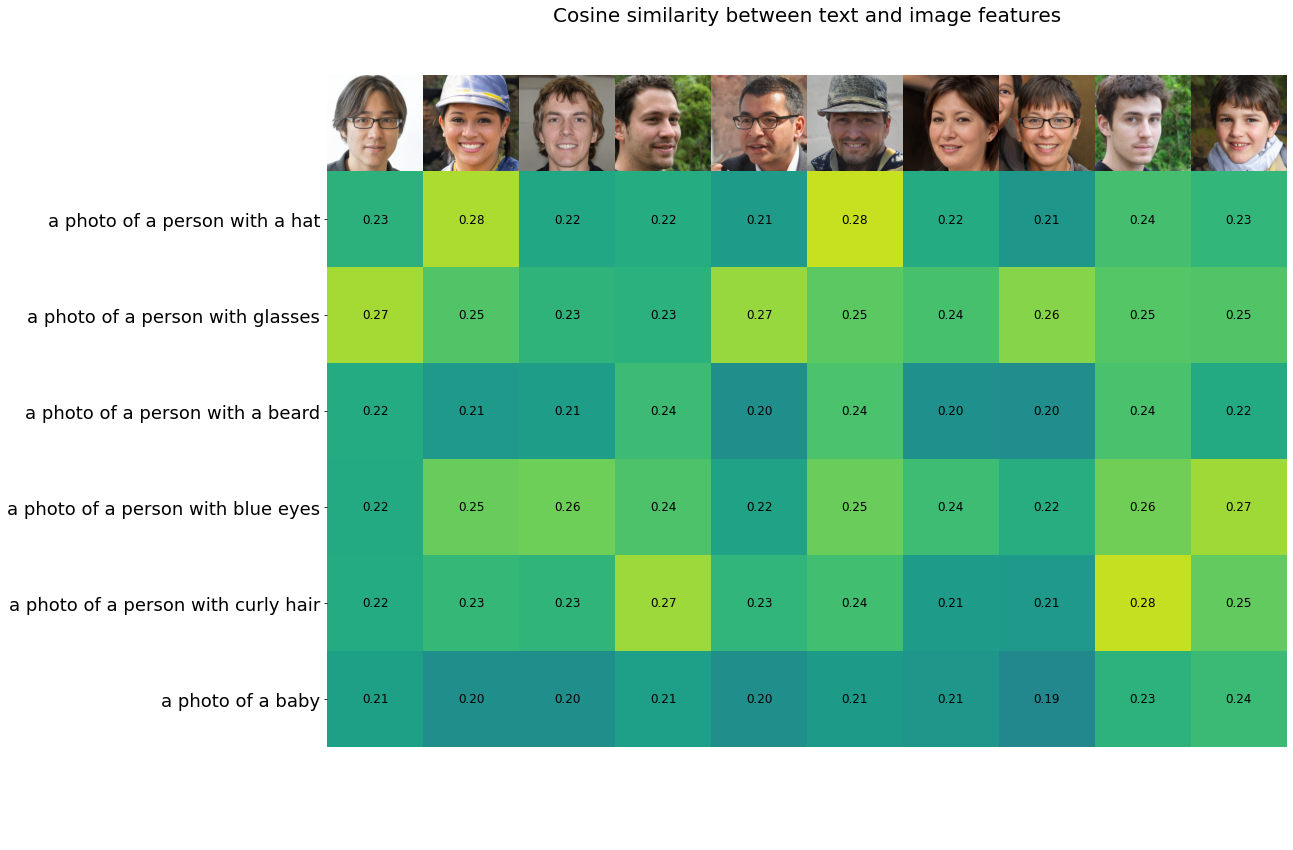

In [38]:
seed = 2
batch_size = 10
batch_data = sample_generator.generate_batch(seed, return_image=True, 
                                             batch_size=batch_size, 
                                             return_style=False)

descs = ["a hat", "glasses", "a beard", "curly hair"] 

texts = ["a photo of a person with " + desc for desc in descs]
texts.append("a photo of a baby")
#texts.append("a photo of a person on a blue background")

get_similarity(batch_data["image"], texts)

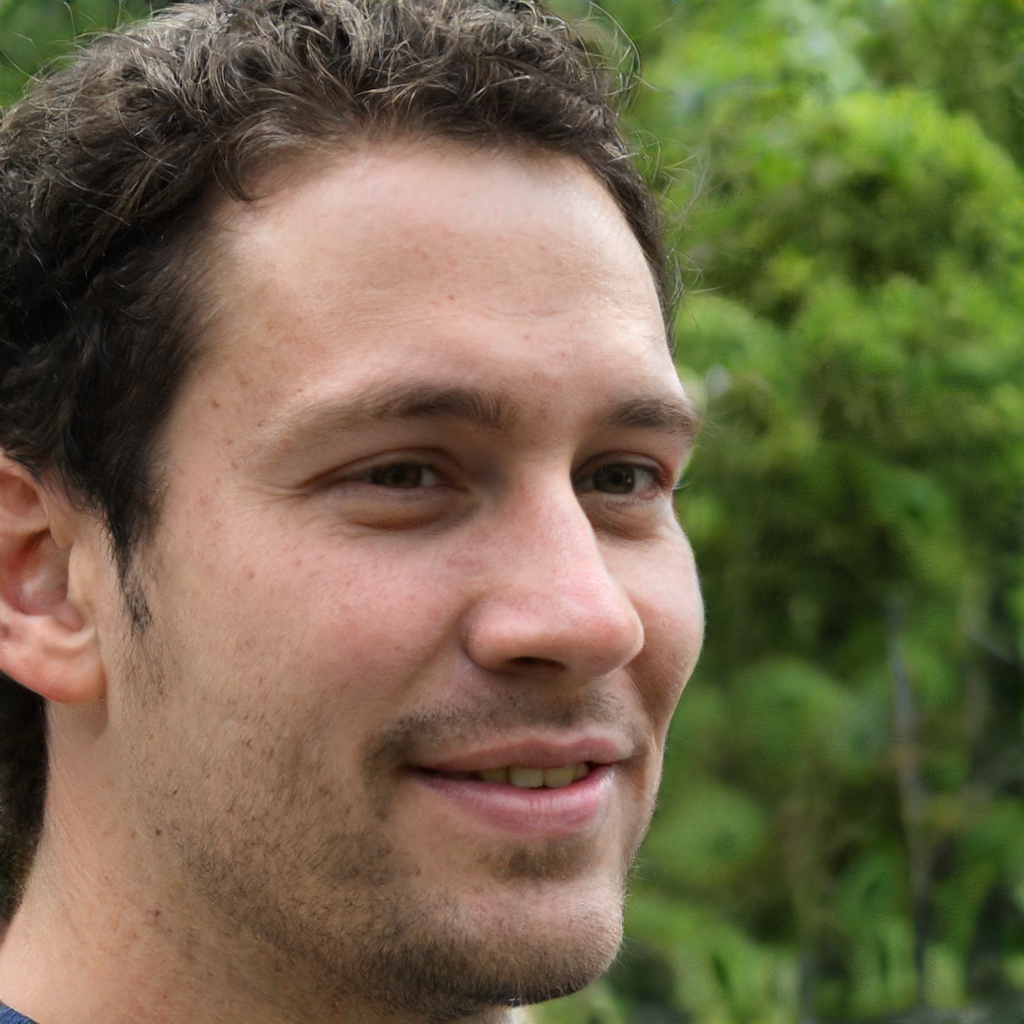

In [41]:
batch_data["image"][3]

In [ ]:
ws = batch_data["ws"]
ws[:, 1, :] += 1

Text(0.5, 1.0, 'Cosine similarity between text and image features')

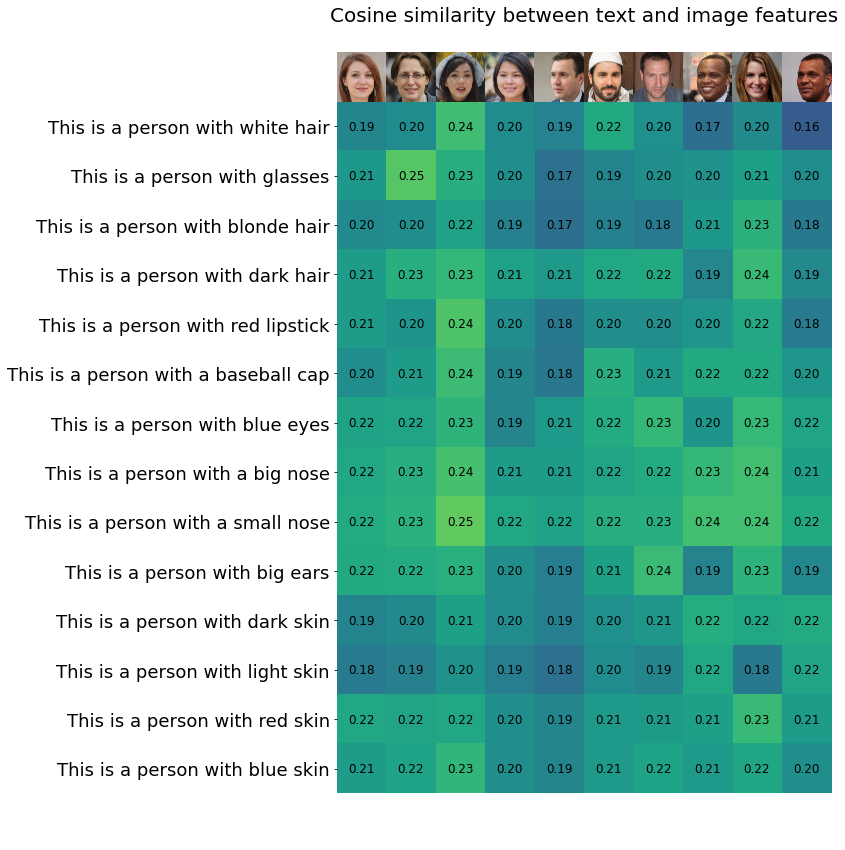

In [ ]:
new_batch_data = sample_generator.generate_batch_from_ws(ws, return_image=True)
descs = ["white hair", "glasses", "blonde hair", "dark hair", "red lipstick", "a baseball cap", "blue eyes", "a big nose", "a small nose", "big ears", "dark skin", "light skin", "red skin", "blue skin"]
get_similarity(new_batch_data["image"], descs)